In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [30]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import torch.nn.init as init
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.manifold import TSNE
import torchvision.transforms as T


## Hyperparameters

In [3]:
BATCH_SIZE = 128
LATENT_DIM = 6
LAMBDA_Z = 1e-4
LAMBDA_PAIR = 1e-4

## Dataset Preprocessing and Preparation

In [4]:
class EmojiDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.files = [f for f in os.listdir(root) if f.endswith(".png")]

        self.transform = T.Compose([
            T.Resize((128, 128)),
            T.ToTensor(),               #converts to [0,1]
            # T.Normalize([0.5], [0.5])   
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.files[idx])
        img = Image.open(image_path).convert("RGBA")   
        img = img.convert("RGB")
        img = self.transform(img)
        return img

In [5]:
dataset = EmojiDataset("data/noto-128")

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [6]:
imgs = next(iter(loader))
print(imgs.shape)

torch.Size([32, 3, 128, 128])


## Model

In [7]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, latent_dim: int):
    super().__init__()
    #encoder
    self.fc_mu = nn.Linear(128, latent_dim)
    self.fc_logvar = nn.Linear(128, latent_dim)

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 128),
      nn.ReLU(),
      nn.Linear(128, 500),
      nn.ReLU(),
      nn.Linear(500, 64*32*32), # (500,) -> (64*32*32,)
      nn.Unflatten(1, (64,32,32)), # (64*32*32,) -> (64, 32, 32)
      nn.ReLU(),

      nn.ConvTranspose2d(64,32, stride = 2, padding = 1, kernel_size = 4), #(64, 32, 32) -> (32, 64, 64)
      nn.ConvTranspose2d(32, 3, stride = 2, padding = 1, kernel_size = 4), #(32, 64, 64) -> (3, 128, 128)
      nn.Sigmoid(),
    )
    # Encoder convolutional layer
    self.convolutions = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),

      nn.MaxPool2d(kernel_size=2, stride=2), #(32, 128 , 128) -> (32, 64, 64)

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(32, 64, 64) -> (64, 64, 64)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), #(64, 64, 64) -> (64, 32, 32)
      nn.Flatten(), # (64*32*32,)
      nn.Linear(64*32*32, 500), # (64*32*32,) -> (500,)
      nn.ReLU(),
      nn.Linear(500, 128), # (500,) -> (128,)
      nn.ReLU(),
    )

  def encode(self,x):
    x = self.convolutions(x)

    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)

    return mu, logvar

  def reparametrize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)
    return (mu + epsilon * std)

  # def decoder(self,z):
  #   return self.decode(z)

  def forward(self,x):
    mu,logvar = self.encode(x)
    z = self.reparametrize(mu,logvar)
    x_hat = self.decoder(z)

    return x_hat, mu, logvar

## Loss

In [8]:
def vae_loss(x, x_hat, mu, logvar, beta = 1.0):
    # EPSILON = 1e-6

    x_flat = x.view(x.size(0), -1)
    x_hat_flat = x_hat.view(x_hat.size(0), -1)

    # x_hat_flat = x_hat_flat.clamp(min = EPSILON, max = 1. - EPSILON)
    # reconstruction loss
    recon_loss = F.binary_cross_entropy(
        x_hat_flat,
        x_flat,
        reduction='sum'
    )
    # logvar = torch.clamp(logvar, max=5.0)
    # kl loss

    kl_loss = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    # if random.random() < 0.0001: # Print ~1 time per epoch
    #     print(f"[DEBUG KL] Raw KL Loss (summed): {kl_loss.item():.4f}")

    return recon_loss, kl_loss, recon_loss + beta * kl_loss

### Convex Regulariser

In [9]:
def pairwise_squared_distances(z):
    B, D = z.shape
    norms = (z * z).sum(dim=1)  # (B,)
    dist2 = norms.unsqueeze(1) + norms.unsqueeze(0) - 2.0 * (z @ z.t())
    offdiag_sum = (dist2.sum() - torch.diagonal(dist2).sum()) * 0.5
    return offdiag_sum

## Sample and Visualise Latent Space

In [22]:
def generate_orig_vs_recons(model, loader, device, num_samples=8):
    model.eval()
    with torch.no_grad():
        x = next(iter(loader))
        x = x.to(device)

        mu, logvar = model.encode(x)
        z = model.reparametrize(mu, logvar)
        x_hat = model.decoder(z)

        x = x.cpu()
        x_hat = x_hat.cpu()

    # Plot originals vs reconstructions
    plt.figure(figsize=(15, 4))

    for i in range(num_samples):
        # --------- ORIGINAL ---------
        ax = plt.subplot(2, num_samples, i + 1)
        img = x[i].permute(1, 2, 0).numpy()     # C H W --> H W C
        img = np.clip(img, 0, 1)                # safety
        plt.imshow(img)
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

        # --------- RECONSTRUCTION ---------
        ax = plt.subplot(2, num_samples, i + 1 + num_samples)
        img_hat = x_hat[i].permute(1, 2, 0).numpy()
        img_hat = np.clip(img_hat, 0, 1)
        plt.imshow(img_hat)
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstructed")

    plt.suptitle("Original (Top) vs Reconstructed (Bottom)", fontsize=14)
    plt.show()

    return x, x_hat


## Train

In [16]:
def train(model, dataloader, optimizer, device, epoch, total_epochs, target_beta, FREEZE_EPOCHS):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    total_steps = num_batches * total_epochs
    start_step = (epoch - 1) * num_batches
    total_annealing_steps = total_steps

    # decoder freeze
    if epoch <= FREEZE_EPOCHS:
        for param in model.decoder.parameters():
            param.requires_grad = False # freeze decoder weights
        initial_beta = 0.1
    else:
        for param in model.decoder.parameters():
            param.requires_grad = True # unfreeze decoder weights



    for batch_idx, x in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}/{total_epochs} Training")):

        # for the first FREEZE_EPOCHS, weights of the decoder are frozen to give high gradient to KL term
        if epoch <= FREEZE_EPOCHS:
          current_beta = initial_beta
        else:
          current_step = batch_idx + start_step
          annealing_factor = min(float(current_step) / total_annealing_steps, 1.0)
          current_beta = annealing_factor * target_beta

        x = x.float()
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)

        z = model.reparametrize(mu, logvar)

        latent_norm = (z.pow(2).sum()) #latent L2 regularizer
        pairwise_term = pairwise_squared_distances(z)

        # Use the determined beta
        recon_loss, kl_loss, loss = vae_loss(x, x_hat, mu, logvar, beta = current_beta)
        loss +=   LAMBDA_Z * latent_norm + LAMBDA_PAIR * pairwise_term

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    recon_loss_ = recon_loss/num_batches
    kl_loss_ = kl_loss/num_batches
    return avg_loss, recon_loss_, kl_loss_

In [17]:
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
model = VariationalAutoEncoder(LATENT_DIM).to(device)
print(model)

VariationalAutoEncoder(
  (fc_mu): Linear(in_features=128, out_features=6, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=6, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=65536, bias=True)
    (5): Unflatten(dim=1, unflattened_size=(64, 32, 32))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): Sigmoid()
  )
  (convolutions): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, pad

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

Epoch 1/100 Training: 100%|██████████| 118/118 [00:07<00:00, 15.08it/s]


Epoch [1/100] | Train Loss: 8.2169 | Recon Loss: 418318.6022 | KL Loss: 2799.5017


Epoch 2/100 Training: 100%|██████████| 118/118 [00:08<00:00, 14.54it/s]


Epoch [2/100] | Train Loss: 8.6584 | Recon Loss: 417353.7050 | KL Loss: 2470.7019


Epoch 3/100 Training: 100%|██████████| 118/118 [00:08<00:00, 14.30it/s]


Epoch [3/100] | Train Loss: 9.8012 | Recon Loss: 417309.6690 | KL Loss: 2892.6082


Epoch 4/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.66it/s]


Epoch [4/100] | Train Loss: 11.2860 | Recon Loss: 419952.8194 | KL Loss: 2527.0247


Epoch 5/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.90it/s]


Epoch [5/100] | Train Loss: 10.1553 | Recon Loss: 419684.8268 | KL Loss: 2691.8772


Epoch 6/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.95it/s]


Epoch [6/100] | Train Loss: 10.0783 | Recon Loss: 420064.6867 | KL Loss: 2705.9148


Epoch 7/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.95it/s]


Epoch [7/100] | Train Loss: 9.5347 | Recon Loss: 419846.1687 | KL Loss: 3259.1799


Epoch 8/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [8/100] | Train Loss: 9.3714 | Recon Loss: 419015.4176 | KL Loss: 2604.2214


Epoch 9/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


Epoch [9/100] | Train Loss: 9.6892 | Recon Loss: 418661.8075 | KL Loss: 2648.1812


Epoch 10/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


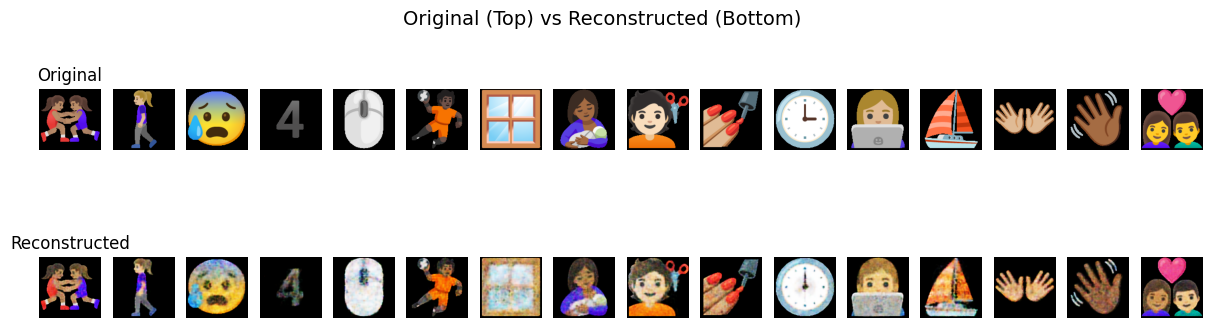

Epoch [10/100] | Train Loss: 10.0024 | Recon Loss: 417447.1102 | KL Loss: 2814.7092


Epoch 11/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [11/100] | Train Loss: 9.8947 | Recon Loss: 417380.4833 | KL Loss: 2783.4902


Epoch 12/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [12/100] | Train Loss: 10.8603 | Recon Loss: 416962.3101 | KL Loss: 2281.4839


Epoch 13/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.85it/s]


Epoch [13/100] | Train Loss: 10.7313 | Recon Loss: 417002.2691 | KL Loss: 2481.1970


Epoch 14/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [14/100] | Train Loss: 10.8680 | Recon Loss: 416228.2826 | KL Loss: 2672.9041


Epoch 15/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [15/100] | Train Loss: 9.1351 | Recon Loss: 415654.0771 | KL Loss: 3159.9548


Epoch 16/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.81it/s]


Epoch [16/100] | Train Loss: 10.9051 | Recon Loss: 415388.2664 | KL Loss: 2488.5535


Epoch 17/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [17/100] | Train Loss: 8.8671 | Recon Loss: 414752.0265 | KL Loss: 2646.5471


Epoch 18/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [18/100] | Train Loss: 10.4087 | Recon Loss: 415128.9812 | KL Loss: 2413.0017


Epoch 19/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [19/100] | Train Loss: 9.0641 | Recon Loss: 414608.8980 | KL Loss: 2836.3682


Epoch 20/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


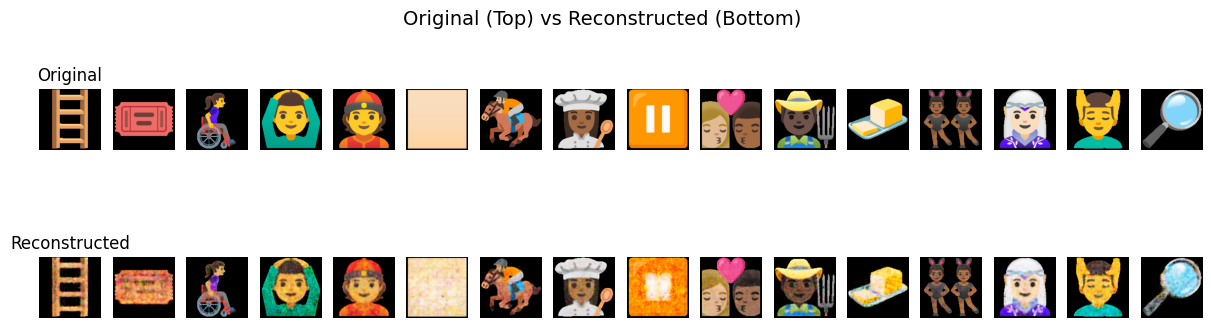

Epoch [20/100] | Train Loss: 9.0981 | Recon Loss: 414263.2405 | KL Loss: 2377.1658


Epoch 21/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [21/100] | Train Loss: 10.1760 | Recon Loss: 414408.0310 | KL Loss: 2815.9189


Epoch 22/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch [22/100] | Train Loss: 10.9117 | Recon Loss: 413518.5098 | KL Loss: 2736.3423


Epoch 23/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [23/100] | Train Loss: 9.6348 | Recon Loss: 413423.6367 | KL Loss: 2637.1897


Epoch 24/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.86it/s]


Epoch [24/100] | Train Loss: 9.4627 | Recon Loss: 413243.7733 | KL Loss: 2330.5237


Epoch 25/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.82it/s]


Epoch [25/100] | Train Loss: 9.2407 | Recon Loss: 412640.1859 | KL Loss: 2547.1323


Epoch 26/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.85it/s]


Epoch [26/100] | Train Loss: 9.4338 | Recon Loss: 412407.4513 | KL Loss: 2331.9519


Epoch 27/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [27/100] | Train Loss: 9.3672 | Recon Loss: 411915.0781 | KL Loss: 2528.2830


Epoch 28/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.95it/s]


Epoch [28/100] | Train Loss: 8.6369 | Recon Loss: 411871.5516 | KL Loss: 2776.4365


Epoch 29/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [29/100] | Train Loss: 8.9075 | Recon Loss: 412034.0048 | KL Loss: 2489.3306


Epoch 30/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]


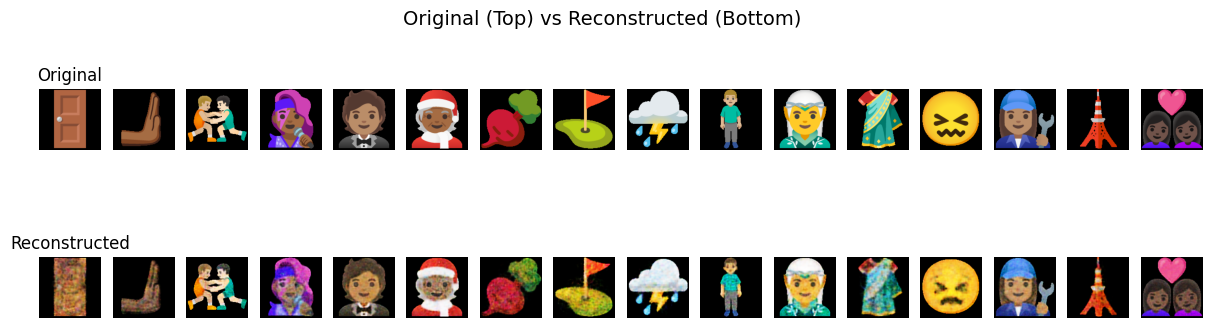

Epoch [30/100] | Train Loss: 9.0565 | Recon Loss: 412250.0757 | KL Loss: 2484.0967


Epoch 31/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.33it/s]


Epoch [31/100] | Train Loss: 9.7175 | Recon Loss: 412162.3570 | KL Loss: 2557.7739


Epoch 32/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


Epoch [32/100] | Train Loss: 8.1662 | Recon Loss: 411697.7730 | KL Loss: 2947.3518


Epoch 33/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.56it/s]


Epoch [33/100] | Train Loss: 8.8503 | Recon Loss: 410943.9952 | KL Loss: 2629.9458


Epoch 34/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.85it/s]


Epoch [34/100] | Train Loss: 8.6059 | Recon Loss: 410287.7868 | KL Loss: 2574.2058


Epoch 35/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [35/100] | Train Loss: 7.9290 | Recon Loss: 410292.7338 | KL Loss: 2601.1550


Epoch 36/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [36/100] | Train Loss: 8.0594 | Recon Loss: 410193.2357 | KL Loss: 2539.5737


Epoch 37/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [37/100] | Train Loss: 8.5248 | Recon Loss: 409455.3724 | KL Loss: 2493.3347


Epoch 38/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.98it/s]


Epoch [38/100] | Train Loss: 8.8453 | Recon Loss: 409390.8141 | KL Loss: 2477.0471


Epoch 39/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.93it/s]


Epoch [39/100] | Train Loss: 8.3763 | Recon Loss: 409996.5418 | KL Loss: 2823.4207


Epoch 40/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.82it/s]


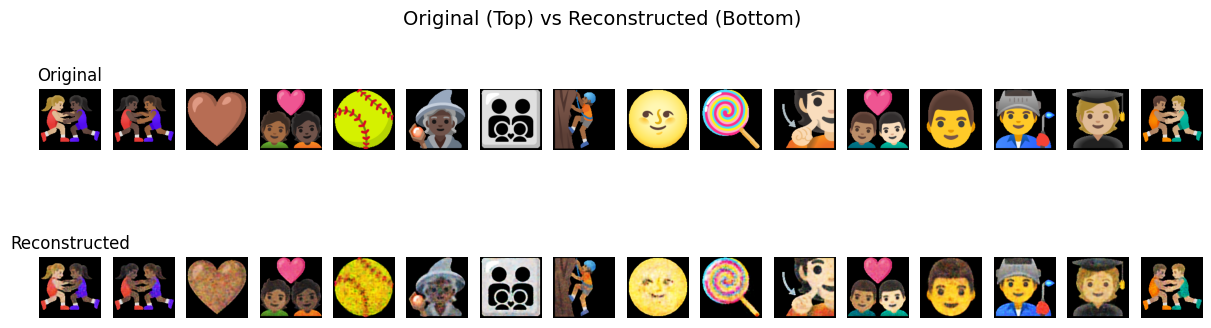

Epoch [40/100] | Train Loss: 9.0328 | Recon Loss: 409324.0358 | KL Loss: 2263.2302


Epoch 41/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [41/100] | Train Loss: 7.9423 | Recon Loss: 409569.3528 | KL Loss: 2395.0312


Epoch 42/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch [42/100] | Train Loss: 9.1502 | Recon Loss: 409047.8215 | KL Loss: 2713.9751


Epoch 43/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]


Epoch [43/100] | Train Loss: 8.1273 | Recon Loss: 408194.7669 | KL Loss: 2788.9834


Epoch 44/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [44/100] | Train Loss: 7.7076 | Recon Loss: 408354.3438 | KL Loss: 3110.3188


Epoch 45/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [45/100] | Train Loss: 8.3100 | Recon Loss: 408994.7667 | KL Loss: 2459.8186


Epoch 46/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [46/100] | Train Loss: 8.0297 | Recon Loss: 408654.4007 | KL Loss: 2954.1462


Epoch 47/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.65it/s]


Epoch [47/100] | Train Loss: 8.3508 | Recon Loss: 408455.6446 | KL Loss: 2213.9504


Epoch 48/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [48/100] | Train Loss: 7.8265 | Recon Loss: 408263.1200 | KL Loss: 2566.7056


Epoch 49/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.85it/s]


Epoch [49/100] | Train Loss: 7.1111 | Recon Loss: 408270.1351 | KL Loss: 2970.3008


Epoch 50/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


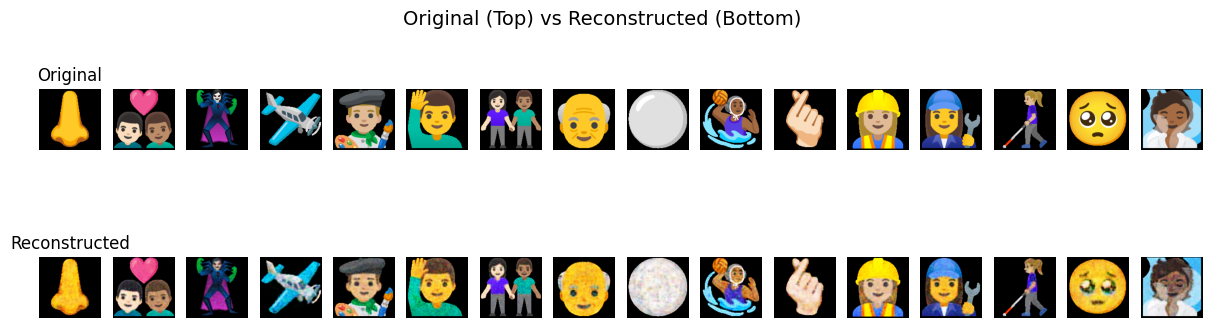

Epoch [50/100] | Train Loss: 8.3487 | Recon Loss: 407886.6811 | KL Loss: 2753.3330


Epoch 51/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [51/100] | Train Loss: 8.0557 | Recon Loss: 408259.0225 | KL Loss: 2580.2659


Epoch 52/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [52/100] | Train Loss: 7.8177 | Recon Loss: 407947.7786 | KL Loss: 2765.2778


Epoch 53/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [53/100] | Train Loss: 8.5467 | Recon Loss: 407283.3332 | KL Loss: 2419.1653


Epoch 54/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch [54/100] | Train Loss: 8.4079 | Recon Loss: 407607.0162 | KL Loss: 2714.5149


Epoch 55/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.92it/s]


Epoch [55/100] | Train Loss: 8.8550 | Recon Loss: 407428.7540 | KL Loss: 2599.3025


Epoch 56/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.88it/s]


Epoch [56/100] | Train Loss: 8.0794 | Recon Loss: 407293.7495 | KL Loss: 2463.3977


Epoch 57/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [57/100] | Train Loss: 8.3915 | Recon Loss: 406836.9288 | KL Loss: 2456.3147


Epoch 58/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


Epoch [58/100] | Train Loss: 8.2496 | Recon Loss: 406713.6706 | KL Loss: 2790.1589


Epoch 59/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [59/100] | Train Loss: 6.7852 | Recon Loss: 407010.4163 | KL Loss: 2551.4756


Epoch 60/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]


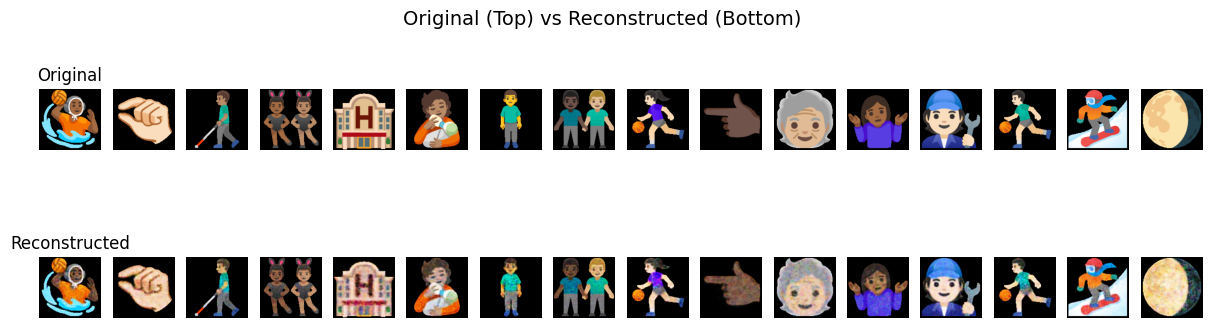

Epoch [60/100] | Train Loss: 7.6336 | Recon Loss: 407027.3114 | KL Loss: 2757.1499


Epoch 61/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.95it/s]


Epoch [61/100] | Train Loss: 7.6383 | Recon Loss: 406482.5553 | KL Loss: 2777.7930


Epoch 62/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.91it/s]


Epoch [62/100] | Train Loss: 7.8801 | Recon Loss: 406462.6960 | KL Loss: 2778.4822


Epoch 63/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch [63/100] | Train Loss: 7.2591 | Recon Loss: 406677.7172 | KL Loss: 2707.6807


Epoch 64/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch [64/100] | Train Loss: 7.5241 | Recon Loss: 406598.0416 | KL Loss: 2500.4646


Epoch 65/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch [65/100] | Train Loss: 8.0924 | Recon Loss: 406121.7805 | KL Loss: 2452.6746


Epoch 66/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [66/100] | Train Loss: 6.8770 | Recon Loss: 405764.6046 | KL Loss: 2489.0730


Epoch 67/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


Epoch [67/100] | Train Loss: 6.1669 | Recon Loss: 405821.2595 | KL Loss: 2776.6250


Epoch 68/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


Epoch [68/100] | Train Loss: 7.3260 | Recon Loss: 405979.8181 | KL Loss: 2653.4121


Epoch 69/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [69/100] | Train Loss: 6.8929 | Recon Loss: 405529.7887 | KL Loss: 2431.4731


Epoch 70/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.74it/s]


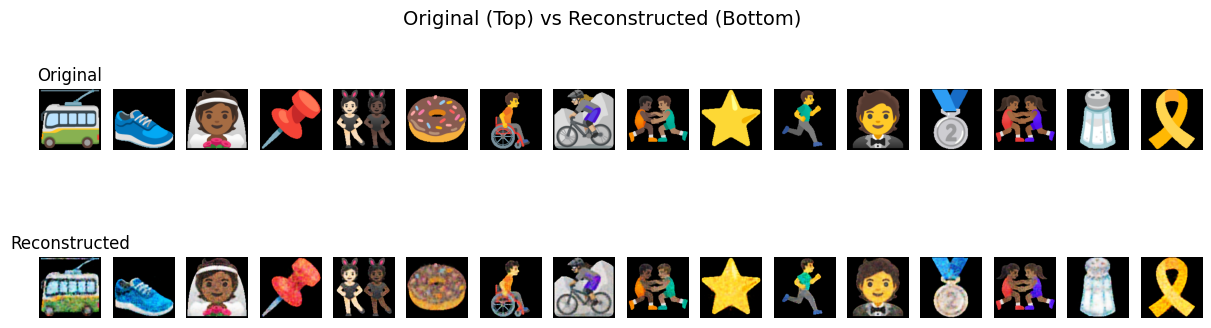

Epoch [70/100] | Train Loss: 6.5999 | Recon Loss: 405491.5953 | KL Loss: 2890.6826


Epoch 71/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.61it/s]


Epoch [71/100] | Train Loss: 6.6355 | Recon Loss: 405978.5135 | KL Loss: 2823.3928


Epoch 72/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.94it/s]


Epoch [72/100] | Train Loss: 7.4970 | Recon Loss: 405261.9870 | KL Loss: 2695.0278


Epoch 73/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


Epoch [73/100] | Train Loss: 6.4460 | Recon Loss: 405166.0416 | KL Loss: 2463.9412


Epoch 74/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [74/100] | Train Loss: 7.0094 | Recon Loss: 405417.5101 | KL Loss: 2837.9746


Epoch 75/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.87it/s]


Epoch [75/100] | Train Loss: 6.2919 | Recon Loss: 405187.4039 | KL Loss: 2567.3167


Epoch 76/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [76/100] | Train Loss: 7.3321 | Recon Loss: 405133.9860 | KL Loss: 2601.7822


Epoch 77/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.70it/s]


Epoch [77/100] | Train Loss: 6.6021 | Recon Loss: 404842.6989 | KL Loss: 2706.5964


Epoch 78/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.85it/s]


Epoch [78/100] | Train Loss: 6.6479 | Recon Loss: 404788.0291 | KL Loss: 2650.7563


Epoch 79/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


Epoch [79/100] | Train Loss: 6.5077 | Recon Loss: 404560.7786 | KL Loss: 2565.8350


Epoch 80/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.86it/s]


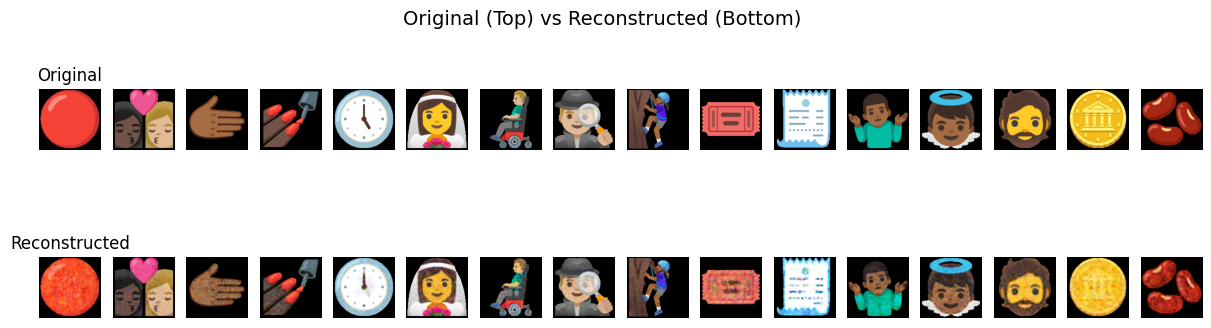

Epoch [80/100] | Train Loss: 7.1975 | Recon Loss: 404534.8848 | KL Loss: 2520.9719


Epoch 81/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch [81/100] | Train Loss: 6.2679 | Recon Loss: 404427.2797 | KL Loss: 2500.9600


Epoch 82/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [82/100] | Train Loss: 7.3899 | Recon Loss: 404238.0757 | KL Loss: 2686.9880


Epoch 83/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.91it/s]


Epoch [83/100] | Train Loss: 7.3402 | Recon Loss: 404439.6239 | KL Loss: 2031.4821


Epoch 84/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch [84/100] | Train Loss: 6.9342 | Recon Loss: 404267.6298 | KL Loss: 2591.0508


Epoch 85/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [85/100] | Train Loss: 6.5097 | Recon Loss: 404148.4203 | KL Loss: 2407.1882


Epoch 86/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch [86/100] | Train Loss: 7.1637 | Recon Loss: 404142.8069 | KL Loss: 2444.0168


Epoch 87/100 Training: 100%|██████████| 118/118 [00:08<00:00, 14.01it/s]


Epoch [87/100] | Train Loss: 6.9656 | Recon Loss: 404467.3581 | KL Loss: 2517.8318


Epoch 88/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


Epoch [88/100] | Train Loss: 6.5472 | Recon Loss: 404609.2638 | KL Loss: 2862.1526


Epoch 89/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


Epoch [89/100] | Train Loss: 5.9333 | Recon Loss: 403855.8490 | KL Loss: 2530.8762


Epoch 90/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


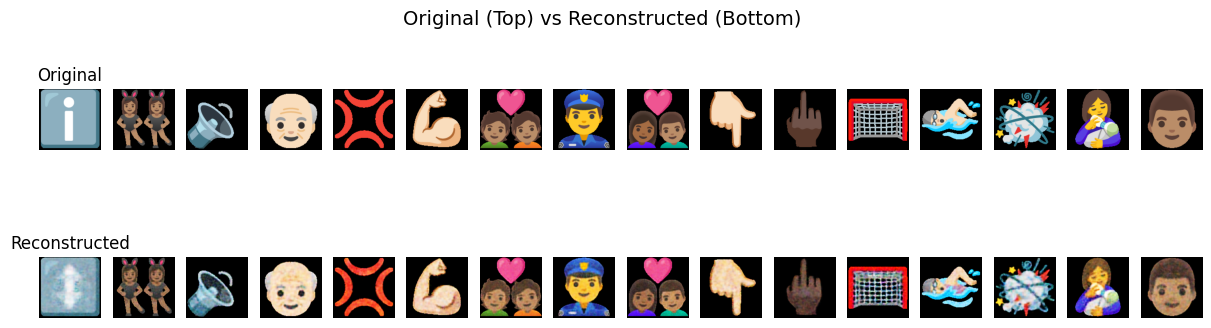

Epoch [90/100] | Train Loss: 7.0412 | Recon Loss: 403385.5252 | KL Loss: 2432.1584


Epoch 91/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [91/100] | Train Loss: 6.2053 | Recon Loss: 404092.9544 | KL Loss: 2424.6299


Epoch 92/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.80it/s]


Epoch [92/100] | Train Loss: 7.0478 | Recon Loss: 403860.3064 | KL Loss: 2297.0879


Epoch 93/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [93/100] | Train Loss: 6.3741 | Recon Loss: 404189.8509 | KL Loss: 2696.8669


Epoch 94/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [94/100] | Train Loss: 6.2617 | Recon Loss: 404087.9401 | KL Loss: 2451.1741


Epoch 95/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.66it/s]


Epoch [95/100] | Train Loss: 6.2968 | Recon Loss: 403839.1104 | KL Loss: 2753.1758


Epoch 96/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]


Epoch [96/100] | Train Loss: 6.8036 | Recon Loss: 403387.7428 | KL Loss: 2326.7463


Epoch 97/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch [97/100] | Train Loss: 6.5389 | Recon Loss: 403555.9073 | KL Loss: 2704.7197


Epoch 98/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.82it/s]


Epoch [98/100] | Train Loss: 6.7665 | Recon Loss: 403667.8350 | KL Loss: 2480.5842


Epoch 99/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.76it/s]


Epoch [99/100] | Train Loss: 6.5723 | Recon Loss: 403350.7828 | KL Loss: 3079.2659


Epoch 100/100 Training: 100%|██████████| 118/118 [00:08<00:00, 13.83it/s]


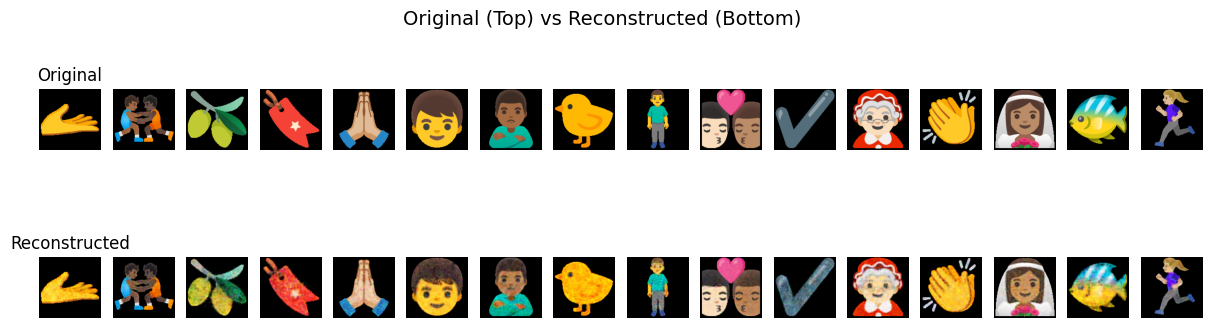

Epoch [100/100] | Train Loss: 6.0757 | Recon Loss: 403266.0050 | KL Loss: 2364.8320


In [23]:
total_epochs = 100
target_beta = 1.0
FREEZE_EPOCHS = 3
train_losses = [] 

for epoch in range(1, total_epochs + 1):
    recon_loss, kl_loss, train_loss = train(model, loader, optimizer, device,
                       epoch, total_epochs, target_beta, FREEZE_EPOCHS)

    if epoch % 10 == 0:
        generated_images = generate_orig_vs_recons(model, loader, device, num_samples=16)

    train_losses.append(train_loss)

    print(f"Epoch [{epoch}/{total_epochs}] | Train Loss: {train_loss:.4f} | Recon Loss: {recon_loss:.4f} | KL Loss: {kl_loss:.4f}")


In [24]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "vae_model.pth")


In [20]:
# model.eval()
# all_mu = []
# all_logvar = []
# all_z = []
# all_labels = []

# with torch.no_grad():
#     for x in loader:
#         x = x.to(device)
#         mu, logvar = model.encode(x)
#         z = model.reparametrize(mu, logvar)
#         x_hat = model.decoder(z)

#         all_mu.append(mu.cpu())
#         all_logvar.append(logvar.cpu())
#         all_z.append(z.cpu())
#         all_labels.append(y)

# #concat batches
# mu = torch.cat(all_mu)
# logvar = torch.cat(all_logvar)
# z = torch.cat(all_z)
# labels = torch.cat(all_labels)

# #plot
# plt.figure(figsize=(8,6))
# scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', s=5)
# plt.colorbar(scatter, label='Class label')
# plt.xlabel("z[0]")
# plt.ylabel("z[1]")
# plt.title("Latent Space Visualization")
# plt.show()


In [36]:
model.eval()

all_z = []
all_x = []

with torch.no_grad():
    for x in loader:
        x = x.to(device)

        mu, logvar = model.encode(x)
        z = model.reparametrize(mu, logvar)

        all_z.append(z.cpu())
        all_x.append(x.cpu())

# Concatenate all batches
all_z = torch.cat(all_z)
all_x = torch.cat(all_x)

# Limit to at most 300 samples for readability
num_samples = min(300, all_z.shape[0])
indices = torch.randperm(all_z.shape[0])[:num_samples]

z_np = all_z.numpy()

# Reduce to 2D
z_2d = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(z_np)

# Convert to tensor for plotting
z_plot = torch.tensor(z_2d)[indices]   # same indices used to subsample x
x_plot = all_x[indices]

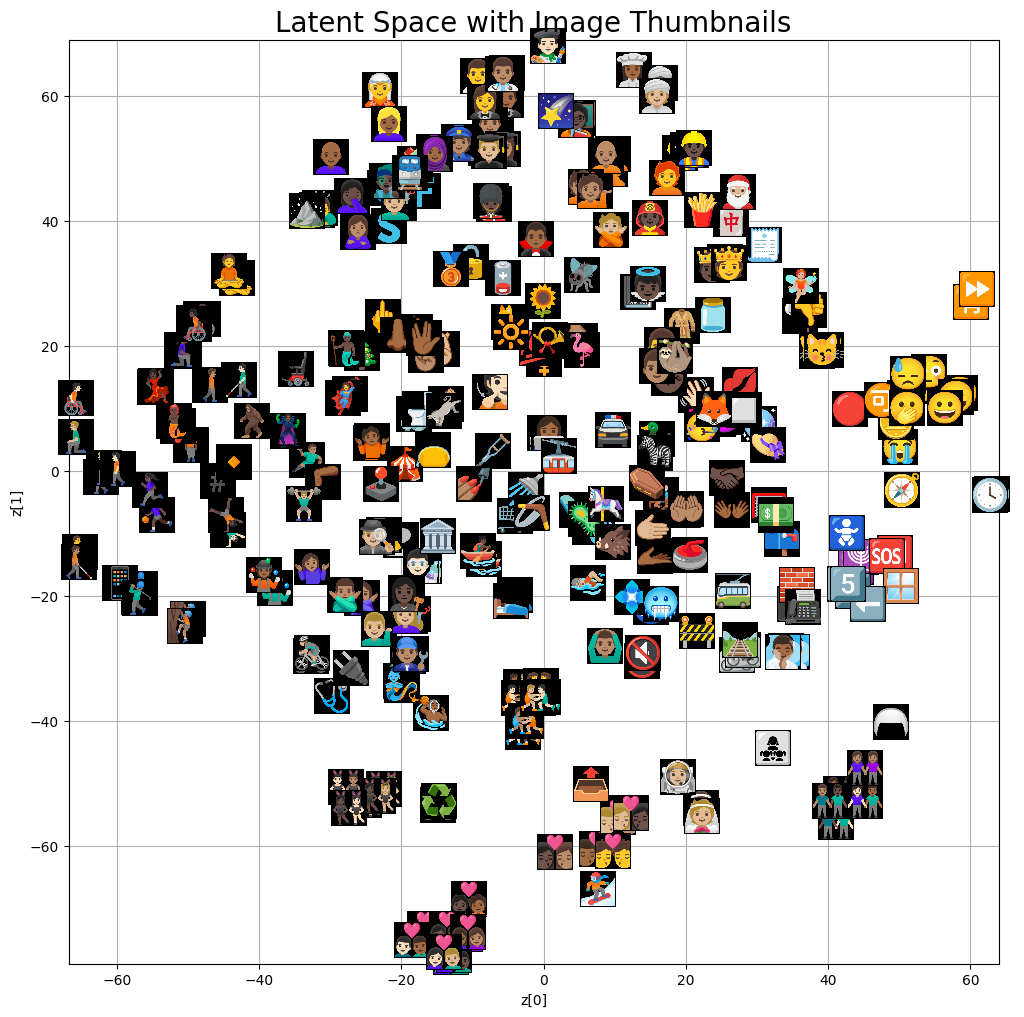

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))

for i in range(num_samples):
    img = x_plot[i].permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    ab = AnnotationBbox(
        OffsetImage(img, zoom=0.2),    
        (z_plot[i, 0].item(), z_plot[i, 1].item()),
        frameon=False
    )
    ax.add_artist(ab)

# Expand axis limits  
ax.set_xlim(z_plot[:,0].min() - 1, z_plot[:,0].max() + 1)
ax.set_ylim(z_plot[:,1].min() - 1, z_plot[:,1].max() + 1)

ax.set_title("Latent Space with Image Thumbnails", fontsize=20)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()